## Initalization and Data Loading

In [61]:
# -*- coding: utf-8 -*-
    
import os
import argparse
import numpy as np
import torch
from torch import nn
from torch import autograd
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from matplotlib import pyplot as plt
from tqdm import tqdm
import scienceplots

In [ ]:
# Adding some arguments
parser = argparse.ArgumentParser(description="A pytorch code for learning and testing state space\
                                 trajectory prediction.")

parser.add_argument("--epochs", default=1500, type=int, help="number of epoches for the model to train")
parser.add_argument("--batch_size", default=512, type=int, help="batch size for training of the model")
parser.add_argument("--dt", default=0.03, type=float, help="size of the time step used in the simulation")
parser.add_argument('--train', default=True, action=argparse.BooleanOptionalAction, help="do you wish to train a new model?")
parser.add_argument("--log", default=True, action=argparse.BooleanOptionalAction, help="using log loss for plotting and such")
parser.add_argument("--eps", default=5.0, type=float, help="small epsilon used for weights reparametrization")
parser.add_argument("--lbfgs", default=True, action=argparse.BooleanOptionalAction, help="use lbfgs for optimization")

args, unknown = parser.parse_known_args()

try:
    args = parser.parse_args()
except SystemExit:
    args = parser.parse_args(args=[])

usage: ipykernel_launcher.py [-h] [--epochs EPOCHS] [--batch_size BATCH_SIZE]
                             [--dt DT] [--train | --no-train]
                             [--log | --no-log] [--eps EPS]
                             [--lbfgs | --no-lbfgs]
ipykernel_launcher.py: error: unrecognized arguments: --f=c:\Users\vvvot\AppData\Roaming\jupyter\runtime\kernel-v3ef4d3e6a5d41d41e10487cf67af9391ee144c4da.json


In [63]:
# Extracting the data
if os.path.exists("data/dataset.txt") is False:
    raise Exception("We don't have any training data. It should be stored as dataset.txt in the folder data.")

with open("data/dataset.txt", "r", encoding="utf-8") as f:
    data_raw = f.read().strip().split("\n\n")

In [64]:
class TrajectoryDataset(Dataset):
        def __init__(self):
                loaded_trajectories = [
                        [[float(value) for value in line.split(',')] for line in mat_str.strip().split('\n')]
                        for mat_str in data_raw
                    ]
                loaded_trajectories = np.array(loaded_trajectories)
                data = loaded_trajectories[:,1:-2,:]
                target = loaded_trajectories[:,2:-1,:]

                global DIMENSION
                DIMENSION = data.shape[2]-1

                self.position = torch.tensor(data[:,:,1:], requires_grad=True).float()
                self.target_pos = torch.tensor(target[:,:,1:], requires_grad=True).float()
                velocity = (data[:, 2:, 1:] - data[:, :-2, 1:]) / (2 * args.dt)

                # boundary conditions
                velocity_first = (data[:, 1:2, 1:] - data[:, 0:1, 1:]) / args.dt
                velocity_last = (data[:, -1:, 1:] - data[:, -2:-1, 1:]) / args.dt
                velocity = np.concatenate([velocity_first, velocity, velocity_last], axis=1)

                self.velocity = torch.tensor(velocity, requires_grad=True).float()
                self.n_samples = self.position.shape[0]

        def __getitem__(self, index):
            return self.position[index], self.target_pos[index], self.velocity[index] 

        def __len__(self):
            return self.n_samples

trajectories = TrajectoryDataset()

DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

torch.set_default_device(DEVICE)
print(f"Using {DEVICE} for tensor calculations")

generator = torch.Generator(device=DEVICE)
generator.manual_seed(42)

Using cuda for tensor calculations


## Defining the Model

In [65]:
def rk4(f, x, time_step):
    """
        Classical 4th order Runge Kutta implementation
    """
    k1i = f(x)
    k2i = f(x + k1i * time_step/2)
    k3i = f(x + k2i * time_step/2)
    k4i = f(x + k3i * time_step)

    return 1/6 * (k1i + 2*k2i + 2*k3i + k4i)

class PositiveLinear(nn.Linear):
    """
        A positive layer that we use to enforce convexity and concavity
    """

    def forward(self, input):
        W = self.weight
        eps_tensor = torch.tensor(args.eps, device=W.device, dtype=W.dtype)

        positive_W = W + torch.exp(-eps_tensor)
        negative_W = torch.exp(W - eps_tensor) 
        reparam_W = torch.where(W >= 0, positive_W, negative_W) 

        return nn.functional.linear(input, reparam_W, self.bias)

In [66]:
class EntropyNetwork(nn.Module):
    """
        For the entropy network we are using a fully input concave neural network achitecture,
        it's a simple alteration of FICNN - fully input convex neural nets
    """
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(DIMENSION, 8)

        self.prop_layer1 = PositiveLinear(8, 8)
        self.lateral_layer1 = nn.Linear(DIMENSION, 8)

        self.prop_layer2 = PositiveLinear(8, 8)
        self.lateral_layer2 = nn.Linear(DIMENSION, 8)

        self.prop_layer3 = PositiveLinear(8, 8)
        self.lateral_layer3 = nn.Linear(DIMENSION, 8)

        self.prop_layer4 = PositiveLinear(8, 8)
        self.lateral_layer4 = nn.Linear(DIMENSION, 8)

        self.output_layer = PositiveLinear(8, 1)
        self.lateral_layer_out = nn.Linear(DIMENSION, 1)

        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                torch.nn.init.kaiming_normal_(module.weight, generator=generator)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x0):
        x = nn.Softplus()(self.input_layer(x0))

        x = nn.Softplus()(self.prop_layer1(x) + self.lateral_layer1(x0))

        x = nn.Softplus()(self.prop_layer2(x) + self.lateral_layer2(x0))

        x = nn.Softplus()(self.prop_layer3(x) + self.lateral_layer3(x0))

        x = nn.Softplus()(self.prop_layer4(x) + self.lateral_layer4(x0))

        S_out = nn.Softplus()(self.output_layer(x) + self.lateral_layer_out(x0))

        return -S_out

class DissipationNetwork(nn.Module):
    """
        For this network we are using a more complex architecture to ensure 
        only a partial convexity of the output with respect to some inputs.
        Specifically: PICNN, source: https://arxiv.org/pdf/1609.07152
    """
    def __init__(self):
        super().__init__()
        # The branch that propagates x directly forward
        self.x_input_layer = nn.Linear(DIMENSION, 8)
        self.x_prop_layer1 = nn.Linear(8, 8)

        # The branch that goes directly between x and x_star
        self.x_lateral_layer_1 = nn.Linear(DIMENSION, 8)
        self.x_lateral_layer_2 = nn.Linear(8, 8)
        self.x_lateral_layer_out = nn.Linear(8, 1)

        # The branch that propagates x_star forward (We need to enforce convexity here)
        self.conjugate_prop_layer_1 = PositiveLinear(8, 8, bias=False)
        self.conjugate_prop_layer_out= PositiveLinear(8, 1, bias=False)

        self.conjugate_prop_layer_1_mid = nn.Linear(8, 8)
        self.conjugate_prop_layer_out_mid = nn.Linear(8, 8)

        # The branch which always starts at x0_star and ends at arbitrary x_star
        self.conjugate_lateral_layer_in = nn.Linear(DIMENSION, 8, bias=False)
        self.conjugate_lateral_layer_1 = nn.Linear(DIMENSION, 8, bias=False)
        self.conjugate_lateral_layer_out = nn.Linear(DIMENSION, 1, bias=False)

        self.conjugate_lateral_layer_in_mid = nn.Linear(DIMENSION, DIMENSION)
        self.conjugate_lateral_layer_1_mid = nn.Linear(8, DIMENSION)
        self.conjugate_lateral_layer_out_mid = nn.Linear(8, DIMENSION)

        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                torch.nn.init.kaiming_normal_(module.weight, generator=generator)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward_raw(self, state, state_conjugate):
        x0 = state
        x0_star = state_conjugate

        x_star = nn.Softplus()(self.x_lateral_layer_1(x0) 
                               + self.conjugate_lateral_layer_in(torch.mul(x0_star, self.conjugate_lateral_layer_in_mid(x0))))
        x = nn.Softplus()(self.x_input_layer(x0))

        x_star = nn.Softplus()(self.x_lateral_layer_2(x) 
                               + self.conjugate_prop_layer_1(torch.mul(x_star, nn.Softplus()(self.conjugate_prop_layer_1_mid(x))))
                                + self.conjugate_lateral_layer_1(torch.mul(x0_star, self.conjugate_lateral_layer_1_mid(x))))
        x = nn.Softplus()(self.x_prop_layer1(x))

        Xi_out = nn.Softplus()(self.x_lateral_layer_out(x) 
                            + self.conjugate_prop_layer_out(torch.mul(x_star, nn.Softplus()(self.conjugate_prop_layer_out_mid(x))))\
                                + self.conjugate_lateral_layer_out(torch.mul(x0_star, self.conjugate_lateral_layer_out_mid(x))))

        return Xi_out
    
    def forward(self, state, state_conjugate):
        x_star_zeros = torch.zeros_like(state, requires_grad=True)
        Xi_raw = self.forward_raw(state, state_conjugate)
        Xi_at_zero = self.forward_raw(state, x_star_zeros)
        Xi = Xi_raw - Xi_at_zero - (state_conjugate * autograd.grad(Xi_at_zero, x_star_zeros,
                                                                     grad_outputs=torch.ones_like(Xi_at_zero), create_graph=True)[0]).sum(dim=-1).unsqueeze(-1)

        return Xi

In [67]:
class GradientDynamics(nn.Module):
    def __init__(self):
        super().__init__()
        self.S = EntropyNetwork()
        self.Xi = DissipationNetwork()
    
    def forward(self, x):
        S = self.S(x)
        x_star = autograd.grad(S, x, grad_outputs=torch.ones_like(S), create_graph=True)[0].float()
        Xi = self.Xi(x,x_star)
        x_dot = autograd.grad(Xi, x_star, grad_outputs=torch.ones_like(Xi), create_graph=True)[0]

        return x_dot

## Training the Model

In [68]:
L = nn.MSELoss()

if args.train:
    training_trajectories, test_trajectories = random_split(trajectories, [0.8, 0.2], generator=generator)
    model = GradientDynamics().to(DEVICE)

    lbfgs_dataloader = DataLoader(dataset=training_trajectories, batch_size=args.batch_size, shuffle=True, generator=generator)
    adam_dataloader = DataLoader(dataset=training_trajectories, batch_size=args.batch_size // 2, shuffle=True, generator=generator)

    adam_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
    lbfgs_optimizer = torch.optim.LBFGS(model.parameters(), lr=1e-1, max_iter=10, history_size=20, line_search_fn='strong_wolfe')

    # Training
    losses = []

    for i in range(args.epochs):
        if i < args.epochs // 2 or not args.lbfgs:
            dataloader = adam_dataloader
            optimizer = adam_optimizer
        else:
            dataloader = lbfgs_dataloader
            optimizer = lbfgs_optimizer

        for j, (pos, targ_pos, veloc) in enumerate(dataloader):
            pos = pos.to(DEVICE)
            targ_pos = targ_pos.to(DEVICE)
            veloc = veloc.to(DEVICE)

            if i < args.epochs // 2 or not args.lbfgs:
                optimizer.zero_grad()
                predicted_veloc = model(pos)
                loss = L(predicted_veloc, veloc)

                loss.backward()
                optimizer.step()

            else:
                def closure():
                    optimizer.zero_grad()
                    predicted_veloc = model(pos)
                    loss = L(predicted_veloc, veloc)

                    loss.backward()
                    return loss

                optimizer.step(closure)

            predicted_veloc = model(pos)
            loss = L(predicted_veloc, veloc)

        if args.log:
            losses.append(np.log(loss.item()))
        else:
            losses.append(loss.item())

        print(f"Epoch no. {i}/{args.epochs} done! Loss: {loss}.", end="\r")

    if os.path.exists("models"):
        torch.save(model.state_dict(), "models/model.pth")
    else:
        os.mkdir("models")
        torch.save(model.state_dict(), "models/model.pth")

else:
    model = GradientDynamics().to(DEVICE)
    model.load_state_dict(torch.load("models/model.pth", weights_only=True))
    model.eval()

if args.train:
    test_pos = trajectories.position[test_trajectories.indices].to(DEVICE)
    test_target_pos = trajectories.target_pos[test_trajectories.indices].to(DEVICE)
    test_vel = trajectories.velocity[test_trajectories.indices].to(DEVICE)


else:
    test_pos = trajectories.position.to(DEVICE)
    test_target_pos = trajectories.target_pos.to(DEVICE)
    test_vel = trajectories.velocity.to(DEVICE)

MSE_loss = L(model(test_pos), test_vel).item()
print(f"Loss on the test set is {MSE_loss}.")

Loss on the test set is 3.069211743422784e-06.84e-06..


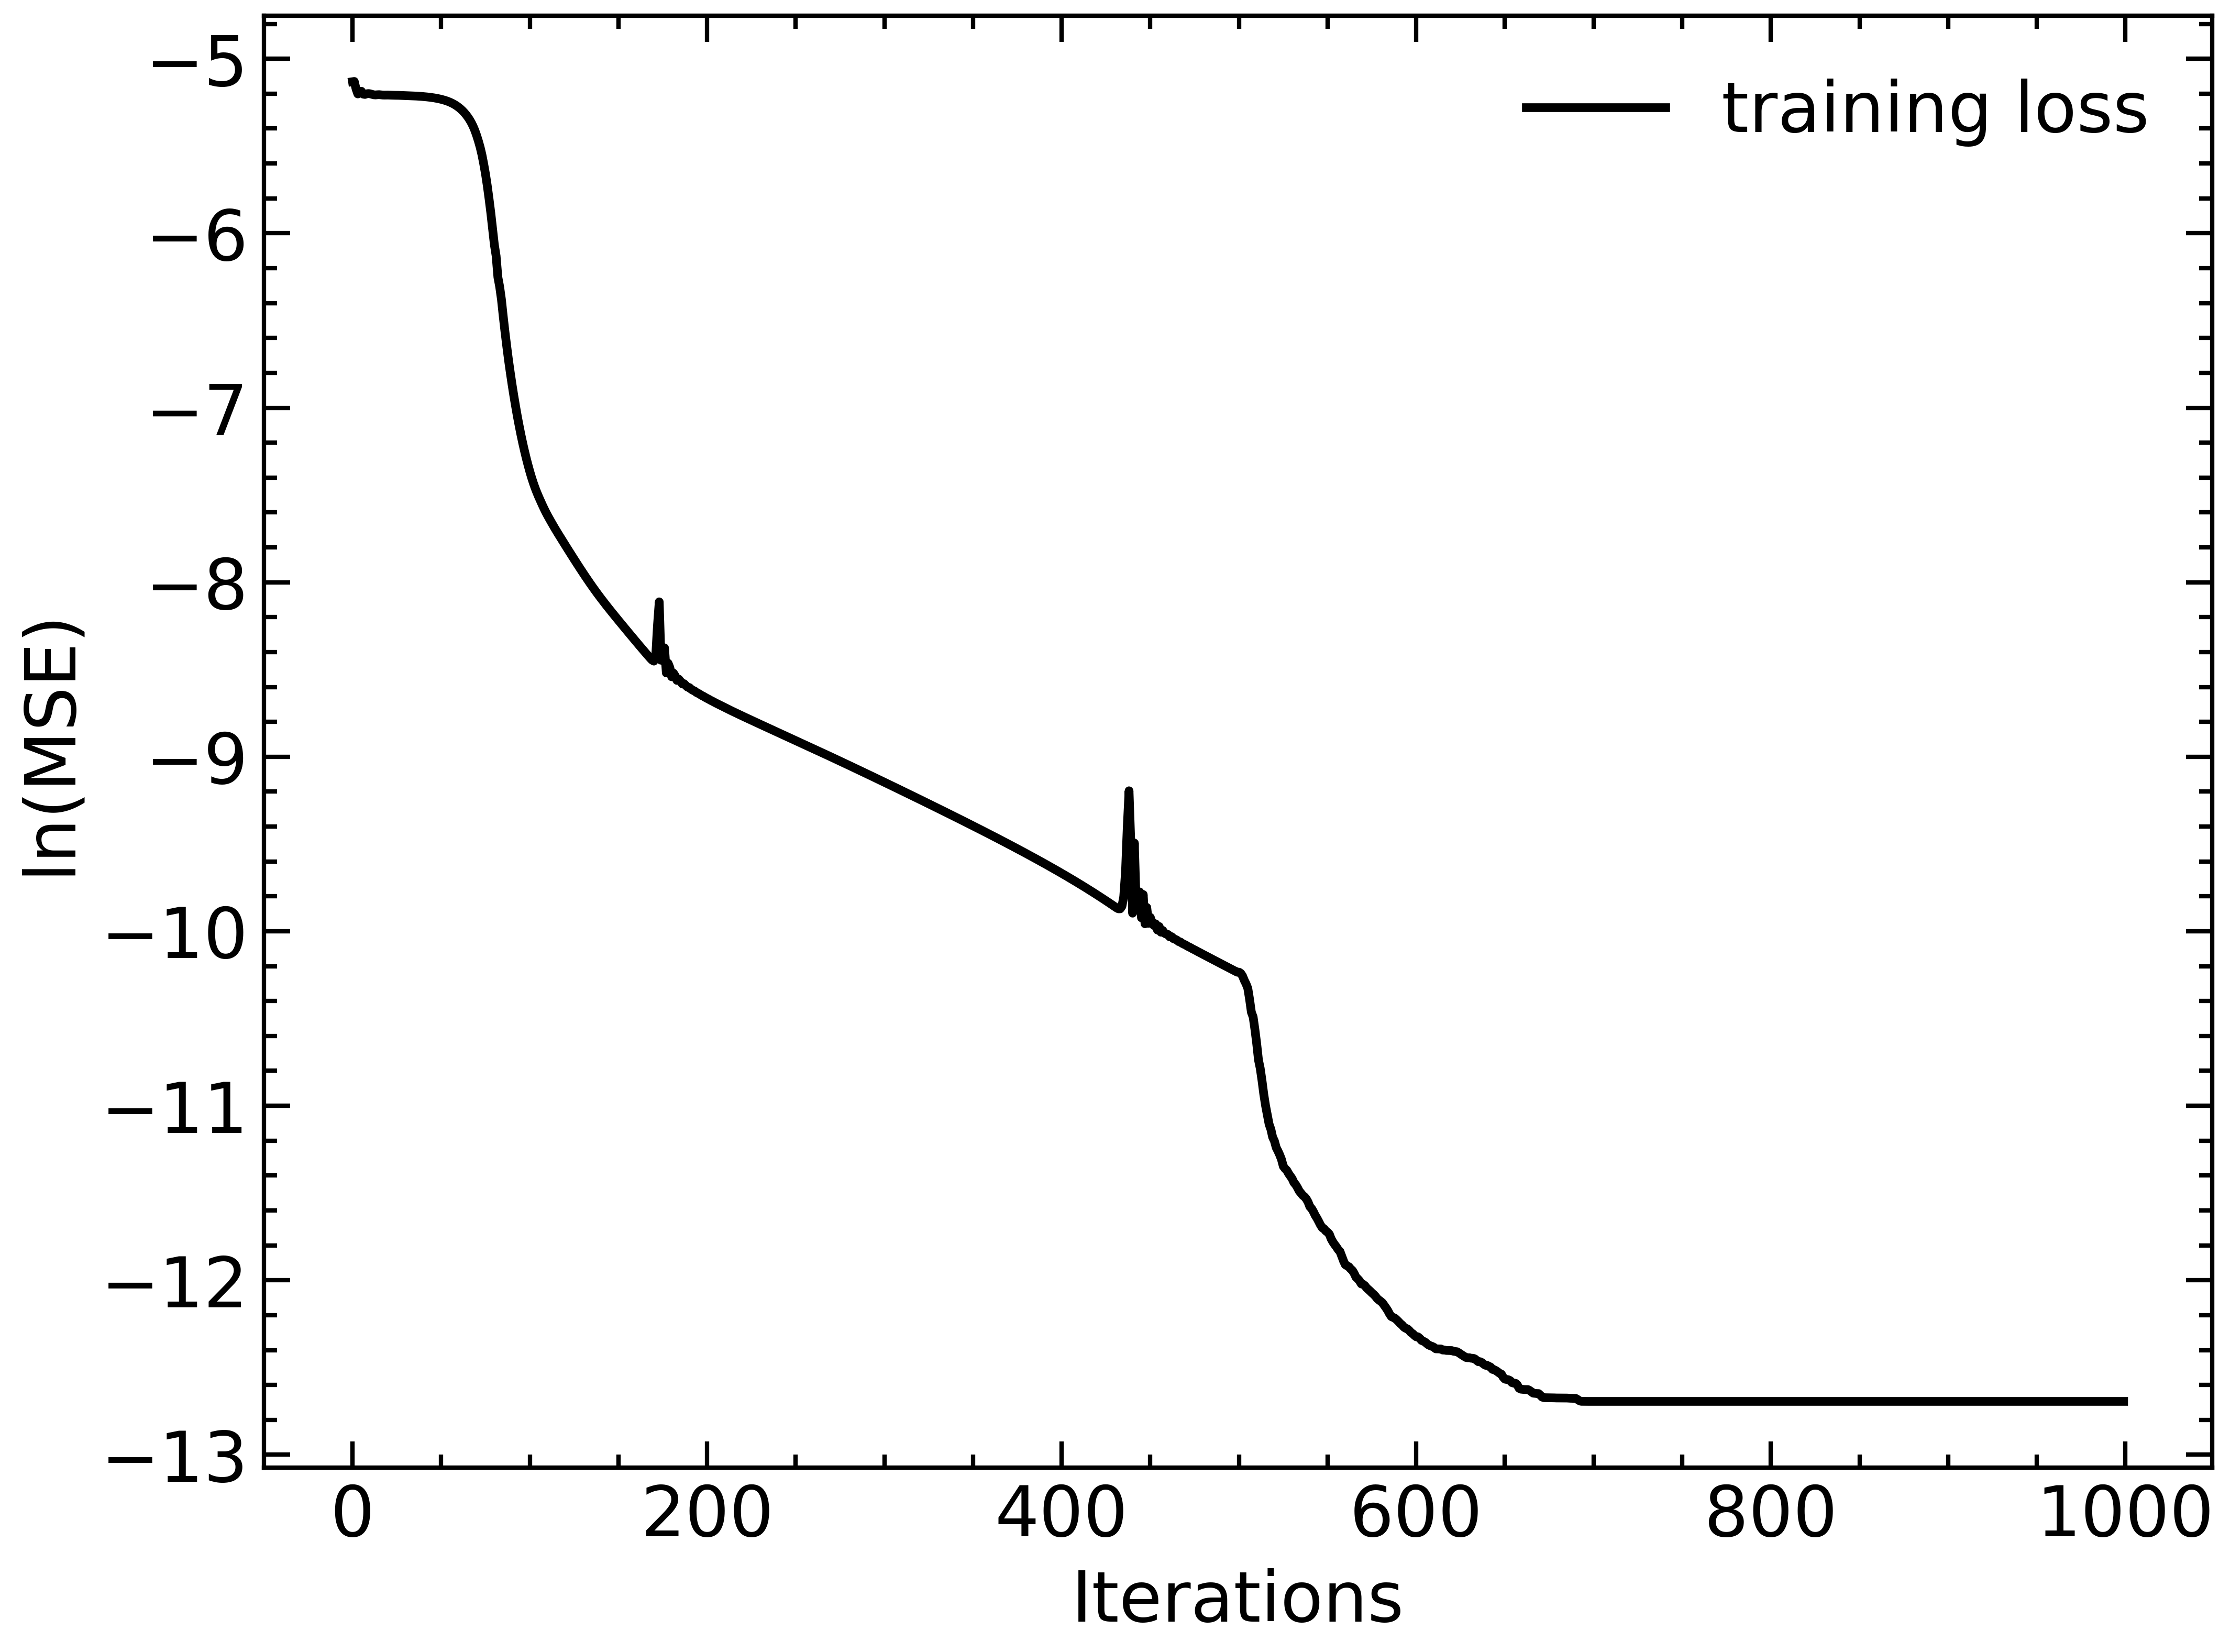

In [69]:
plt.style.use(['science','ieee', 'notebook'])

# Plotting the MSE decline
if args.train:
    fig0,ax0 = plt.subplots()
    ax0.set_xlabel(r"Iterations")
    if args.log:
        ax0.set_ylabel(r"ln(MSE)")
    else:
        ax0.set_ylabel(r"MSE")
    ax0.plot(range(len(losses)), losses, label=r"training loss")
    ax0.legend()

    fig0.savefig("results/loss.pdf")

## Plotting Trajectories 

calculating sample trajectory... it shouldn't take too long


100%|██████████| 61/61 [00:02<00:00, 21.41it/s]


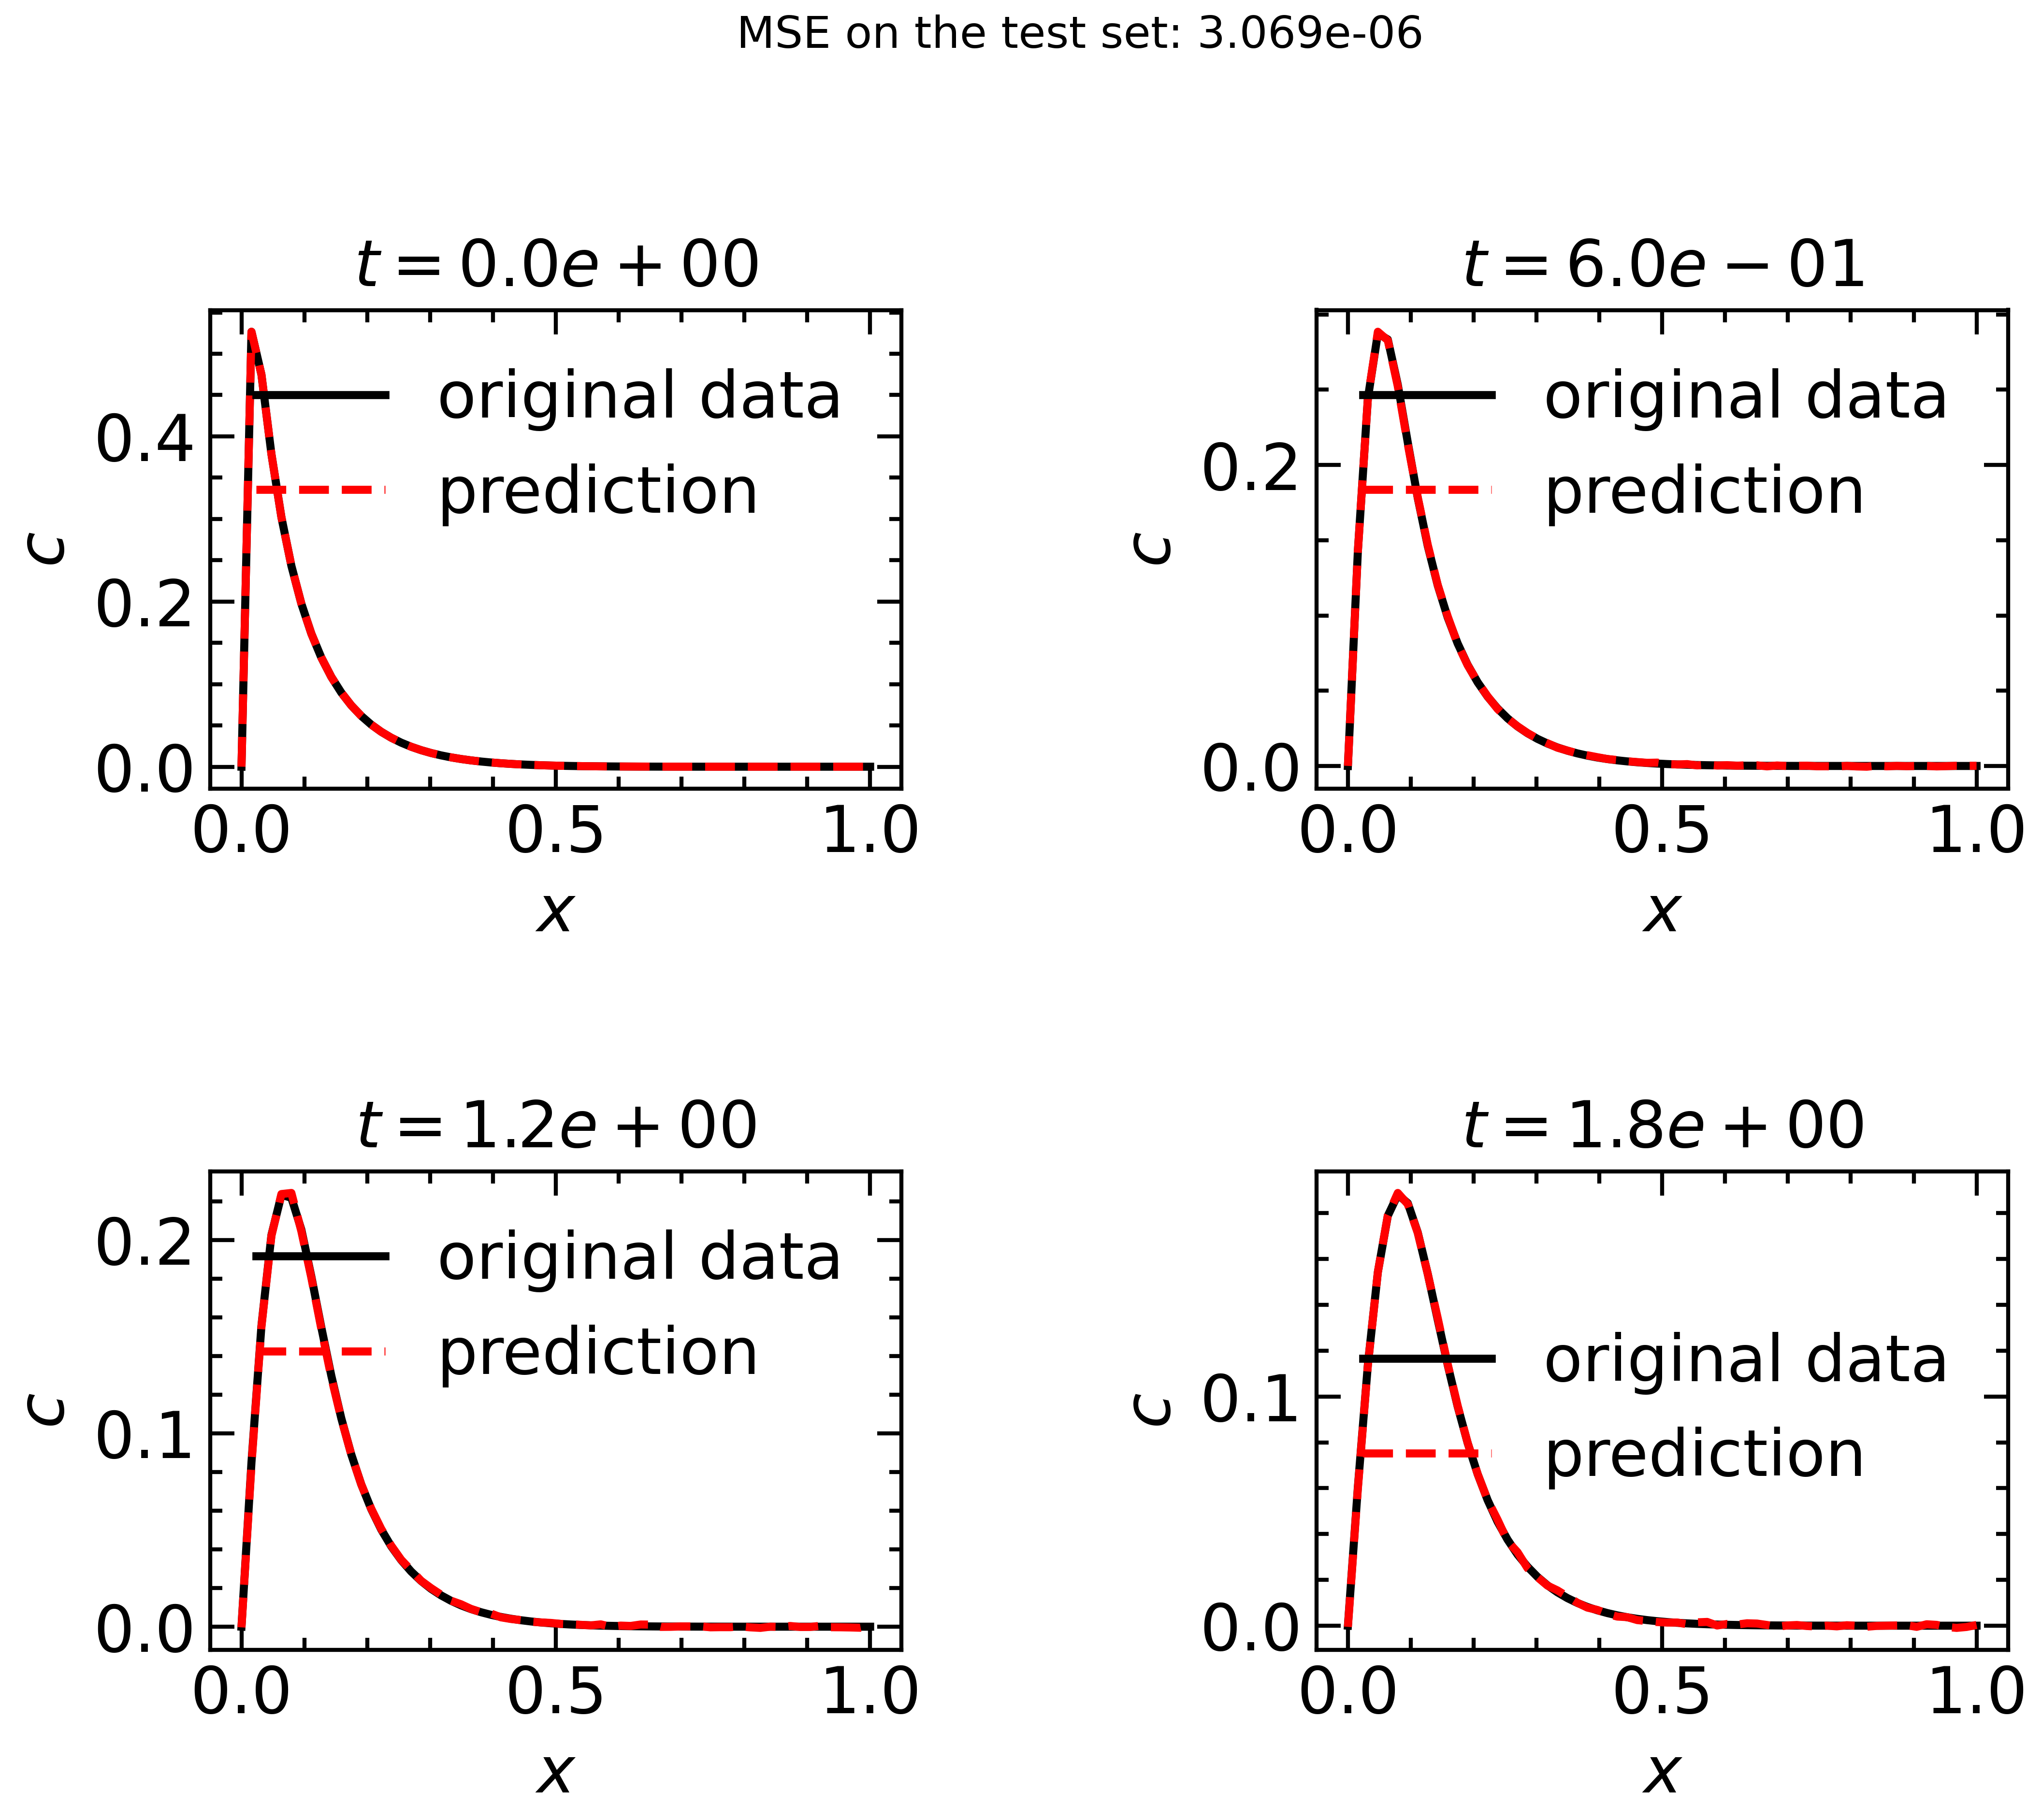

In [ ]:
# Sampling random trajectory and plotting it along with predicted trajectory
plt.style.use(['science','ieee', 'notebook'])
X_GRID = np.linspace(0,1,64)
h = 1/64

fig,axes = plt.subplots(2,2)
axes = axes.flatten()
sample = test_pos[np.random.randint(0,len(test_pos)-1)].cpu().detach().numpy()
tensor_sample = torch.tensor([sample], requires_grad=True)
time_set = [args.dt*i for i in range(len(sample))]

prediction = [sample[0]]
print("calculating sample trajectory... it shouldn't take too long")
for i in tqdm(range(len(sample))):
    velocity = rk4(model, torch.tensor(prediction[i], requires_grad=True), args.dt)
    prediction.append(prediction[i] + args.dt * velocity.cpu().detach().numpy())

prediction = np.array(prediction)
fig.suptitle(f"MSE on the test set: {MSE_loss:.3e}", fontsize=11, y=1.05)

for seq,ax in enumerate(axes):
    ax.plot(X_GRID, sample[int((len(sample)-1) * seq/3)], label=r"original data")
    ax.plot(X_GRID, prediction[int((len(sample)-1) * seq/3)] , label=r"prediction")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$c$")
    ax.set_title(f"$t = {int((len(sample)-1) * seq/3) * args.dt:.1e}$")
    ax.legend()

fig.subplots_adjust(hspace=0.8,wspace=0.6)
fig.savefig("results/trajectory.pdf")

plt.show()

## Plotting Histogram

tensor([3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06,
        3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06,
        3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06,
        3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06,
        3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06,
        3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06,
        3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06,
        3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06,
        3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06,
        3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06,
        3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06,
        3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06, 3.0692e-06,
        3.0692e-06, 3.0692e-06, 3.0692e-

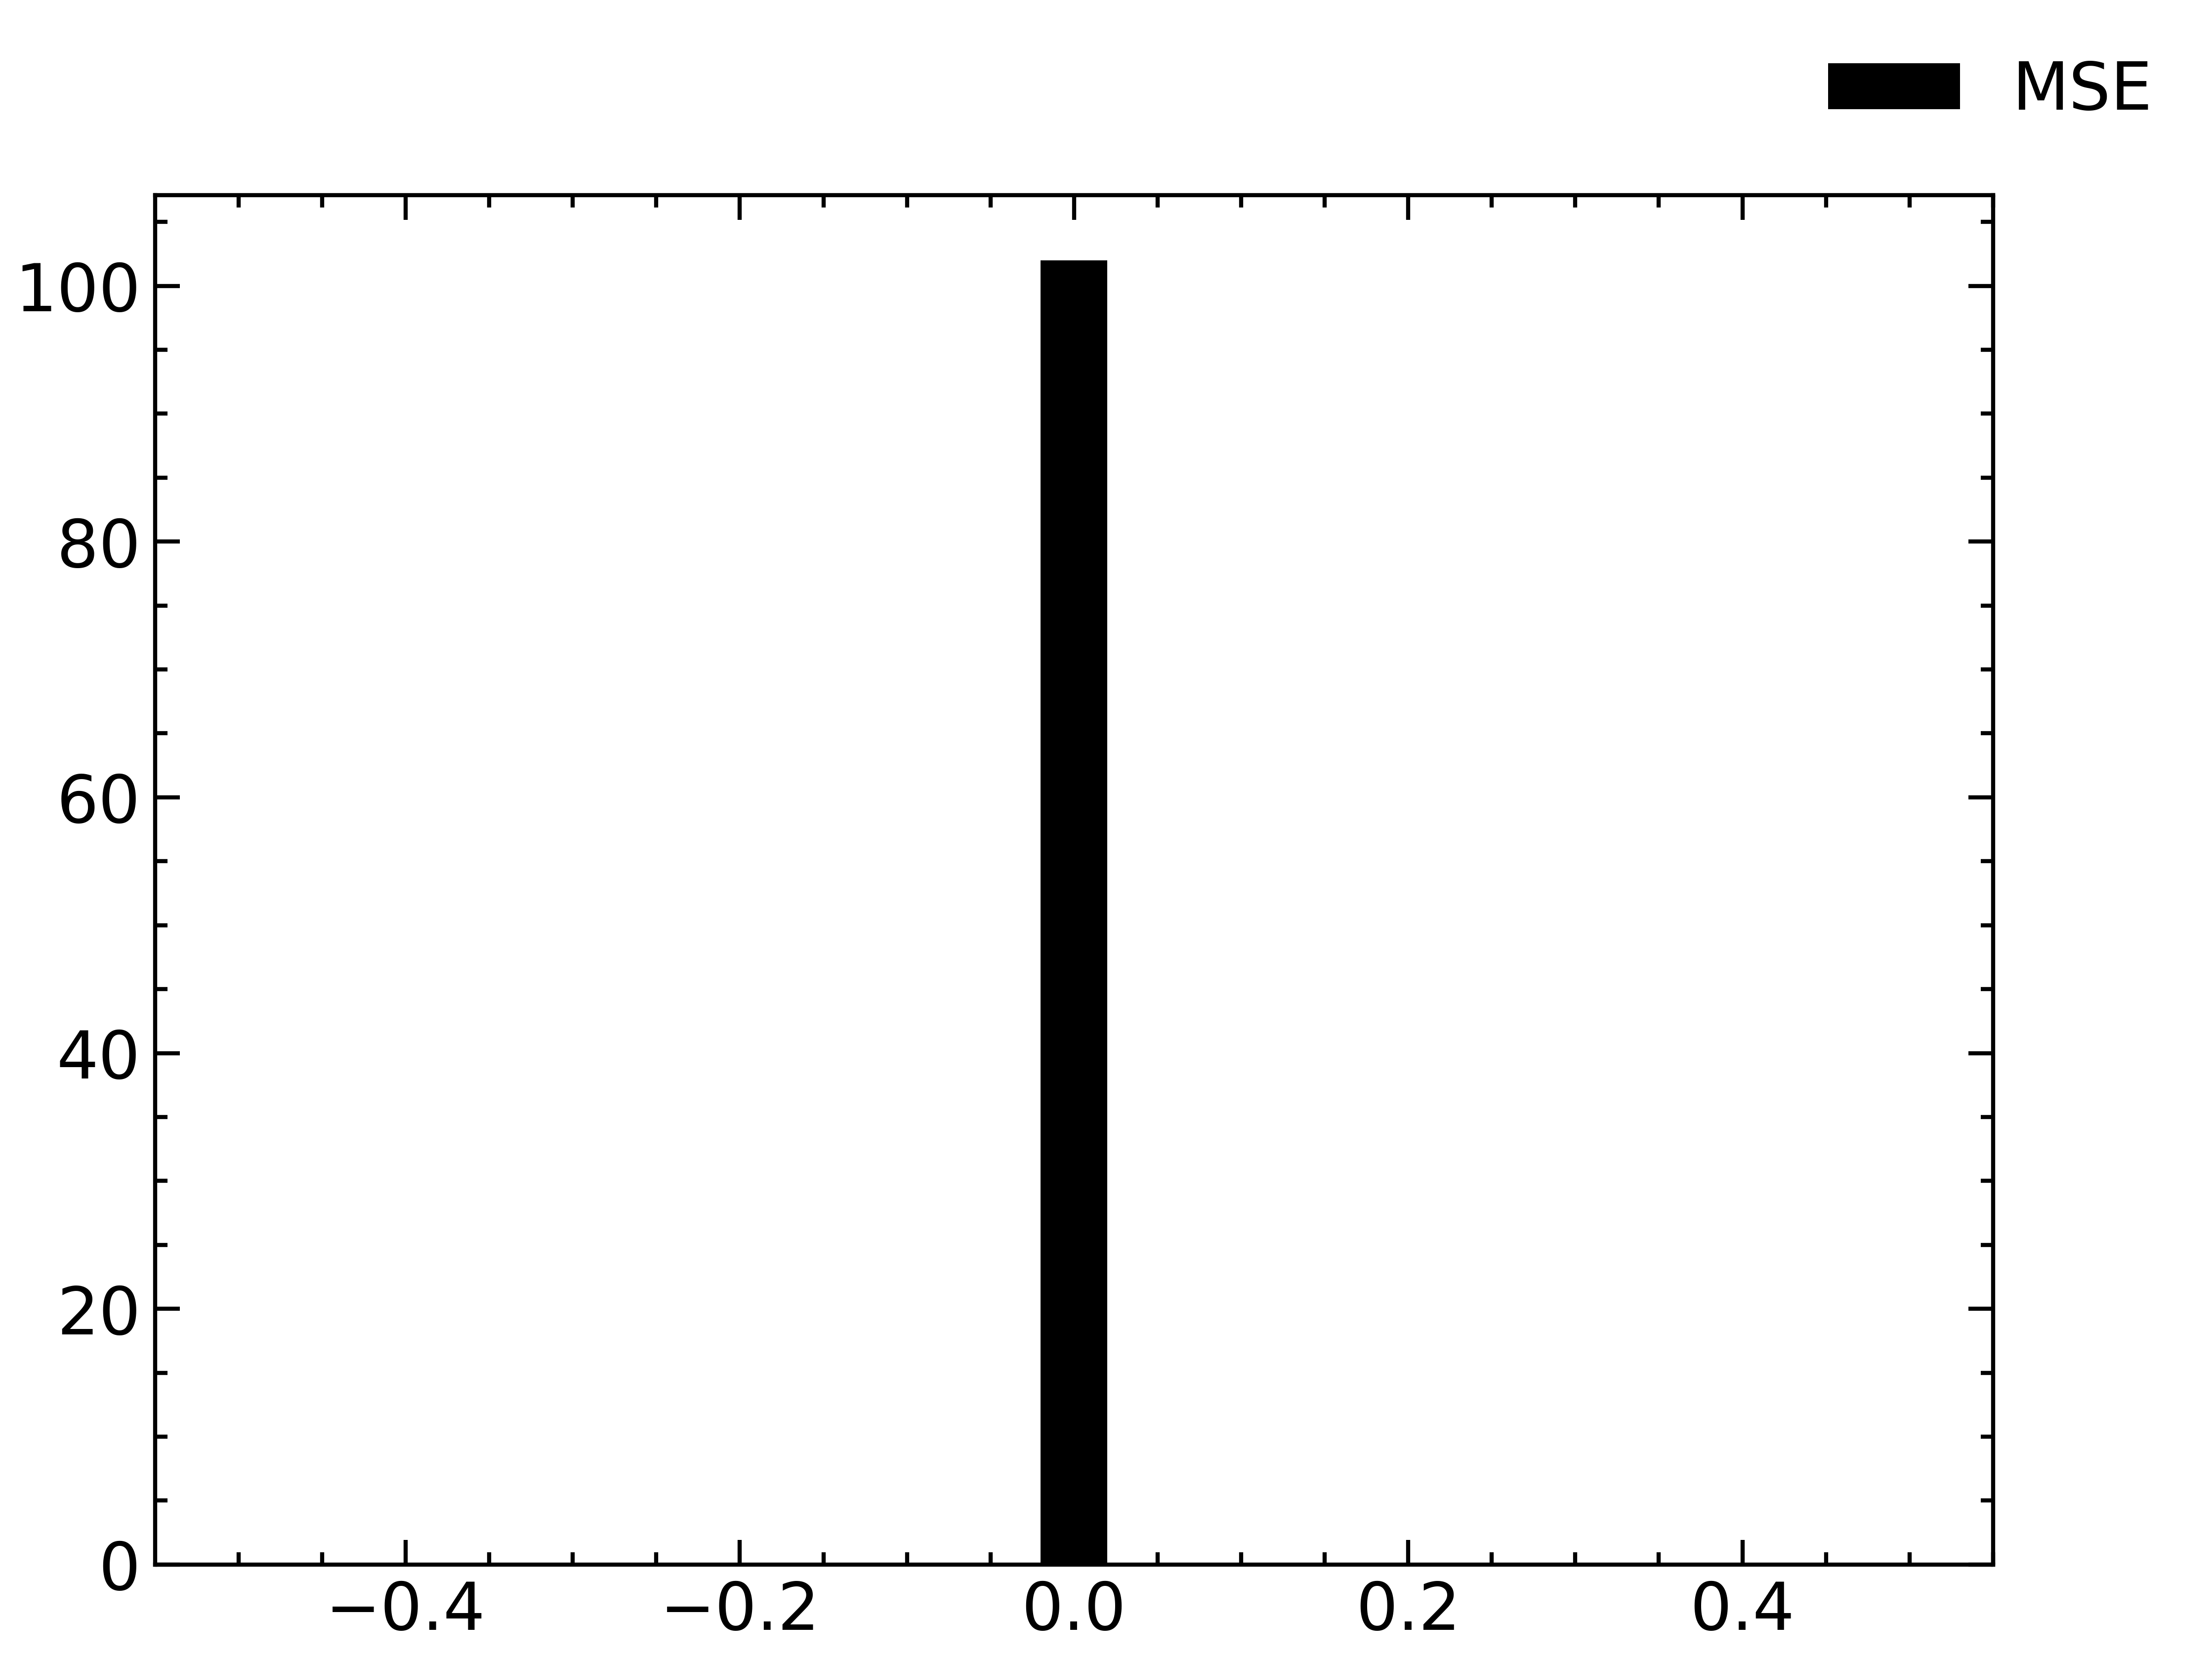

In [ ]:
fig_hist = plt.figure()
ax_hist = fig_hist.add_subplot()

mse_per_trajectory = torch.mean((test_vel - model(test_pos)) ** 2, dim=(1, 2))
ax_hist.hist(mse_per_trajectory.cpu().detach().numpy(), bins=25, label="MSE")

fig_hist.legend()

fig_hist.savefig("results/histogram.pdf")